In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import torch
import numpy as np
import pickle
from lpne.models import DcsfaNmf
from lpne.plotting import circle_plot
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
#from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as image
import os, sys
import seaborn as sns
import pandas as pd
from plot import chord_plot

umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

flx_data_path = "/work/mk423/Anxiety/final_FLX_{}.pkl"
epm_data_path = "/work/mk423/Anxiety/EPM_{}_dict_May_17.pkl"
oft_data_path = "/work/mk423/Anxiety/OFT_{}_dict_old_features_hand_picked.pkl"

anx_info_dict = "/work/mk423/Anxiety/Anx_Info_Dict.pkl"

saved_model_path = "/hpc/home/mk423/Anxiety/FullDataWork/Models/"
saved_model_name = "Final_mt_Model_500_epochs.pt"

projection_save_path = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
plots_path = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

feature_list = ["X_psd","X_coh","X_gc"]
old_feature_list = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]
feature_weights = [10,1,1]

RANDOM_STATE = 42

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
with open(flx_data_path.format("train"),"rb") as f:
    train_dict = pickle.load(f)
    
with open(flx_data_path.format("val"),"rb") as f:
    val_dict = pickle.load(f)
    
with open(flx_data_path.format("test"),"rb") as f:
    test_dict = pickle.load(f)
    
flx_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_train = train_dict['y_flx']
flx_y_mouse_train = train_dict['y_mouse']
flx_y_hab_train = train_dict['y_hab']
flx_y_time_train = train_dict['y_time']

flx_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_val = val_dict['y_flx']
flx_y_mouse_val = val_dict['y_mouse']
flx_y_hab_val = val_dict['y_hab']
flx_y_time_val = val_dict['y_time']

flx_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_test = test_dict['y_flx']
flx_y_mouse_test = test_dict['y_mouse']
flx_y_hab_test = test_dict['y_hab']
flx_y_time_test = test_dict['y_time']
flx_y_expDate_test = test_dict['y_expDate']

#Stack Validation and Training Data from timepoints after 30 minutes
flx_X = np.vstack([flx_X_train[flx_y_hab_train==1],flx_X_val[flx_y_hab_val==1]])
flx_y = np.hstack([flx_y_train[flx_y_hab_train==1],flx_y_val[flx_y_hab_val==1]])
flx_y_mouse = np.hstack([flx_y_mouse_train[flx_y_hab_train==1], flx_y_mouse_val[flx_y_hab_val==1]])

In [3]:
with open(oft_data_path.format("train"),'rb') as f:
    train_dict = pickle.load(f)

with open(oft_data_path.format("validation"),'rb') as f:
    val_dict = pickle.load(f)
    
with open(oft_data_path.format("test"),'rb') as f:
    test_dict = pickle.load(f)
    

running_idx = 0
feature_groups = []
for idx,feature in enumerate(old_feature_list):
    f_begin = running_idx
    f_end = f_begin + train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end

NUM_FREQS = 56
NUM_FEATURES = np.hstack([train_dict[feature] for feature in old_feature_list]).shape[1] // NUM_FREQS
scale_vector = np.array([np.arange(1,NUM_FREQS+1) for feature in range(NUM_FEATURES)]).flatten()

#Train Arrays
oft_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_train = train_dict['y_Homecage'].astype(bool)
oft_y_task_train = ~oft_y_hc_train
oft_y_ROI_train = train_dict['y_ROI']
oft_y_vel_train = train_dict['y_vel']
oft_y_mouse_train = train_dict['y_mouse']
oft_y_time_train = train_dict['y_time']

#Validation Arrays
oft_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_val = val_dict['y_Homecage'].astype(bool)
oft_y_task_val = ~oft_y_hc_val
oft_y_ROI_val = val_dict['y_ROI']
oft_y_vel_val = val_dict['y_vel']
oft_y_mouse_val = val_dict['y_mouse']
oft_y_time_val = val_dict['y_time']

#Test Arrays
oft_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_test = test_dict['y_Homecage'].astype(bool)
oft_y_task_test = ~oft_y_hc_test
oft_y_ROI_test = test_dict['y_ROI']
oft_y_vel_test = test_dict['y_vel']
oft_y_mouse_test = test_dict['y_mouse']
oft_y_time_test = test_dict['y_time']
oft_y_expDate_test = test_dict['y_expDate']

oft_X = np.vstack([oft_X_train,oft_X_val])
oft_y_task = np.hstack([oft_y_task_train,oft_y_task_val])
oft_y_mouse = np.hstack([oft_y_mouse_train,oft_y_mouse_val])

In [4]:
with open(epm_data_path.format("train"),"rb") as f:
    epm_train_dict = pickle.load(f)

with open(epm_data_path.format("val"),"rb") as f:
    epm_validation_dict = pickle.load(f)
    
with open(epm_data_path.format("test"),"rb") as f:
    epm_test_dict = pickle.load(f)

#Load the data
NUM_FREQS = 56
NUM_FEATURES = (epm_train_dict["X_power_1_2"].shape[1] + \
                epm_train_dict["X_coh_1_2"].shape[1] + \
                epm_train_dict["X_gc_1_2"].shape[1]) // NUM_FREQS
SCALE_VECTOR = np.array([np.arange(1,57) for feature in range(NUM_FEATURES)]).flatten()

X_train = np.hstack([epm_train_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
X_train[X_train<0] = 0
y_train = (epm_train_dict['y_ROI']%2).astype(bool)
y_in_task_mask_train = ~epm_train_dict['y_Homecage'].astype(bool)
y_mouse_train = epm_train_dict['y_mouse']
y_time_train = epm_train_dict['y_time']
train_nan_mask = (epm_train_dict['y_ROI'] > 0)


X_train_task = X_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_train_task = y_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_mouse_train_task = y_mouse_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_time_train_task = y_time_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
X_val = np.hstack([epm_validation_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])


y_val = (epm_validation_dict['y_ROI']%2).astype(bool)
y_in_task_mask_val= ~epm_validation_dict['y_Homecage'].astype(bool)
y_mouse_val = epm_validation_dict['y_mouse']
y_time_val = epm_validation_dict['y_time']
val_nan_mask = (epm_validation_dict['y_ROI'] > 0)

X_val_task = X_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_val_task = y_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_mouse_val_task = y_mouse_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_time_val_task = y_time_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]

X_test = np.hstack([epm_test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
y_test = (epm_test_dict['y_ROI']%2).astype(bool)
y_in_task_mask_test= ~epm_test_dict['y_Homecage'].astype(bool)
y_mouse_test = epm_test_dict['y_mouse']
y_time_test = epm_test_dict['y_time']
test_nan_mask = (epm_test_dict['y_ROI'] > 0)
epm_y_expDate_test = epm_test_dict['y_expDate']

X_test_task = X_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_test_task = y_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_mouse_test_task = y_mouse_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_time_test_task = y_time_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]

epm_X = np.vstack([X_train,X_val])
epm_y_task = np.hstack([y_in_task_mask_train,y_in_task_mask_val])
epm_y_mouse = np.hstack([y_mouse_train,y_mouse_val])
epm_y_time = np.hstack([y_time_train,y_time_val])

In [5]:
mt_X_train = np.vstack([flx_X,oft_X,epm_X])
mt_y_train = np.hstack([flx_y,oft_y_task,epm_y_task]).reshape(-1,1)
mt_y_mouse_train = np.hstack([flx_y_mouse,oft_y_mouse,epm_y_mouse])

mt_X_test = np.vstack([flx_X_test[flx_y_hab_test==1],oft_X_test,X_test])
mt_y_test = np.hstack([flx_y_test[flx_y_hab_test==1],oft_y_task_test,y_in_task_mask_test]).reshape(-1,1)
mt_y_mouse_test = np.hstack([flx_y_mouse_test[flx_y_hab_test==1],oft_y_mouse_test,y_mouse_test])

intercept_mask = OneHotEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1)).todense()
sample_groups = OrdinalEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1))
nmf_groups = np.hstack(
    [
        np.ones(flx_X.shape[0])*0,
        np.ones(oft_X.shape[0]),
        np.ones(epm_X.shape[0])*2
    ]
)

In [6]:
model = torch.load(saved_model_path + saved_model_name,map_location="cpu")
model.device="cpu"

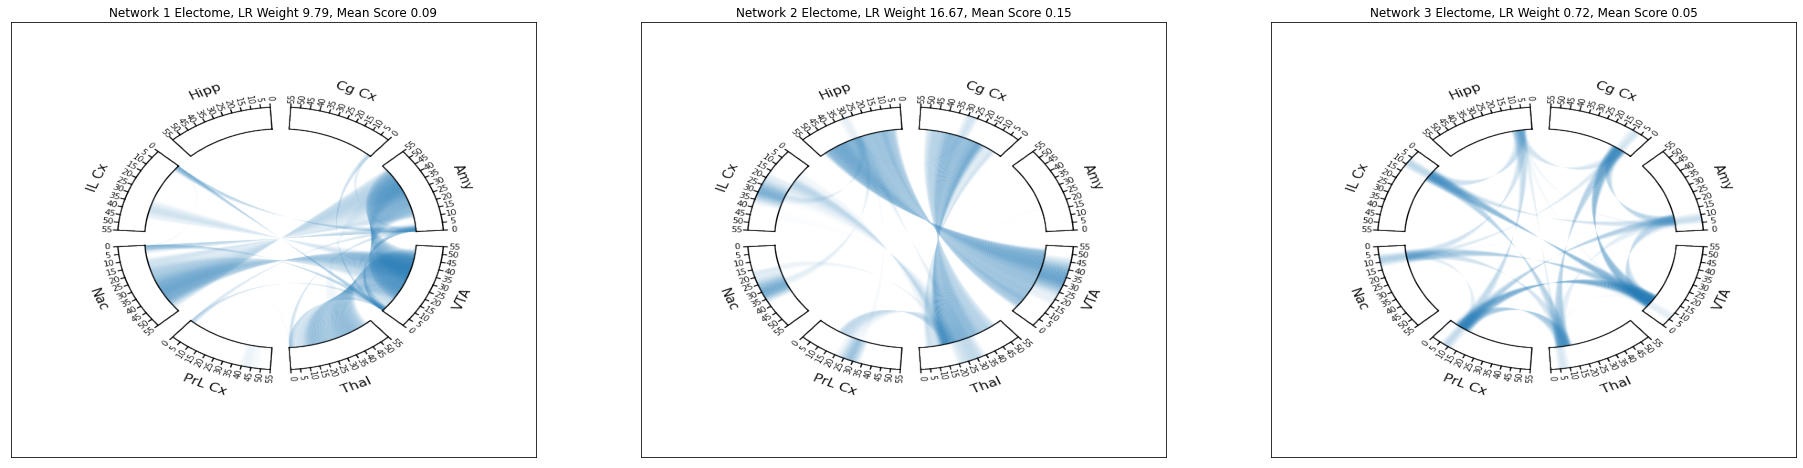

In [17]:
def reshapeData(X_psd,X_coh,n_rois,n_freqs,pow_features,coh_features,areas):
    X_3d = np.zeros((n_rois,n_rois,n_freqs))
    
    for i in range(n_rois):
        X_3d[i,i,:] = X_psd[i*n_freqs:(i+1)*n_freqs]
        
    
    split_coh_features = np.array([feature.split(' ')[0] for feature in coh_features])
    #print(split_coh_features)
    unique_coh_features = np.unique(split_coh_features)
    for i in range(n_rois):
        for j in range(n_rois):
            if i != j:
                area_1 = areas[i]
                area_2 = areas[j]
                temp_feature = area_1 + "-" + area_2
                temp_feature_2 = area_2 + "-" + area_1
                if temp_feature in unique_coh_features:
                    feature_mask = np.where(split_coh_features==temp_feature,True,False)
                    X_3d[i,j,:] = X_coh[feature_mask==1]
                    X_3d[j,i,:] = X_coh[feature_mask==1]

                elif temp_feature_2 in unique_coh_features:
                    feature_mask = np.where(split_coh_features==temp_feature_2,1,0)
                    X_3d[i,j,:] = X_coh[feature_mask==1]
                    X_3d[j,i,:] = X_coh[feature_mask==1]

                else:
                    print("temp_feature: {} not found".format(temp_feature))

    return X_3d

with open("/work/mk423/Anxiety/Anx_Info_Dict.pkl","rb") as f:
    anxInfo = pickle.load(f)

network_list = []

for i in range(3):
    s = model.project(mt_X_train)
    X_sup_recon = model.get_comp_recon(torch.Tensor(s).to("cpu"),i)
    X_recon = model.reconstruct(mt_X_train)

    recon_contribution = np.mean(X_sup_recon/X_recon,axis=0)
    network_list.append(recon_contribution)
    #df = pd.DataFrame(recon_contribution.reshape(1,-1))
    #df.columns = np.hstack([anxInfo["powerFeatures"],anxInfo["cohFeatures"],anxInfo["gcFeatures"]])
    #df.to_csv("/hpc/home/mk423/Anxiety/FullDataWork/Networks/Anxiety_Network_{}.csv".format(i+1))
    rec_psd = recon_contribution[:len(anxInfo["powerFeatures"])]
    rec_coh = recon_contribution[len(anxInfo["powerFeatures"]):(len(anxInfo["powerFeatures"]) + len(anxInfo["cohFeatures"]))]
    rec_3d = reshapeData(rec_psd,rec_coh,8,56,anxInfo["powerFeatures"],anxInfo["cohFeatures"],anxInfo["area"])

    #circle_plot(rec_3d,anxInfo["area"],
    #            freqs=np.arange(56),
    #            freq_ticks=np.arange(0,56,5),
    #            min_max_quantiles=(0.85,0.9999),
    #            fn=plots_path + "color_corrected_final_circos_net_{}.png".format(i))
    
    
    umc_dt.makeUpperTriangularPlot_pow_coh_gc(recon_contribution.reshape(1,-1),anxInfo["area"],anxInfo["powerFeatures"],
                                              anxInfo["cohFeatures"],anxInfo["gcFeatures"],
                                              col2row=True,
                                              title=None,#"Electome {} Expanded".format(i),
                                              saveFile=plots_path + "col2row_color_corrected_final_upper_net_{}.pdf".format(i),
                                             verbose=False)
plt.figure(figsize=(32,8))
for i in range(3):
    plt.subplot(1,3,i+1)
    im = image.imread(plots_path + "color_corrected_final_circos_net_{}.png".format(i))
    plt.imshow(im,aspect="auto")
    plt.title("Network {} Electome, LR Weight {:.2f}, Mean Score {:.2f}".format(i+1, model.classifier[0].weight[0][i].detach().cpu().numpy(),np.mean(s[:,i])))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [21]:
networks_df = {
    "Predictors":np.hstack([anxInfo["powerFeatures"],anxInfo["cohFeatures"],anxInfo["gcFeatures"]]),
    "net 1":network_list[0],
    "net 2":network_list[1],
    "net 3":network_list[2],
}

networks_df = pd.DataFrame.from_dict(networks_df)
networks_df.to_csv("/hpc/home/mk423/Anxiety/FullDataWork/Networks/Anxiety_Electome_Networks.csv",index=False)

In [22]:
networks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5152 entries, 0 to 5151
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Predictors  5152 non-null   object 
 1   net 1       5152 non-null   float32
 2   net 2       5152 non-null   float32
 3   net 3       5152 non-null   float32
dtypes: float32(3), object(1)
memory usage: 100.8+ KB


In [25]:
network_list[2]

array([3.2755593e-06, 1.1289766e-02, 5.4144114e-02, ..., 4.0256409e-06,
       5.3000846e-03, 3.7120601e-06], dtype=float32)

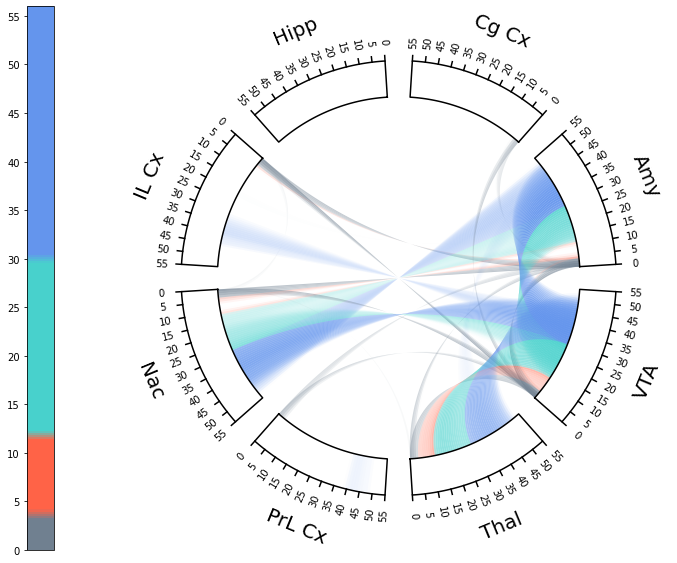

Net 0 Cutoff: 0.33110300898551936


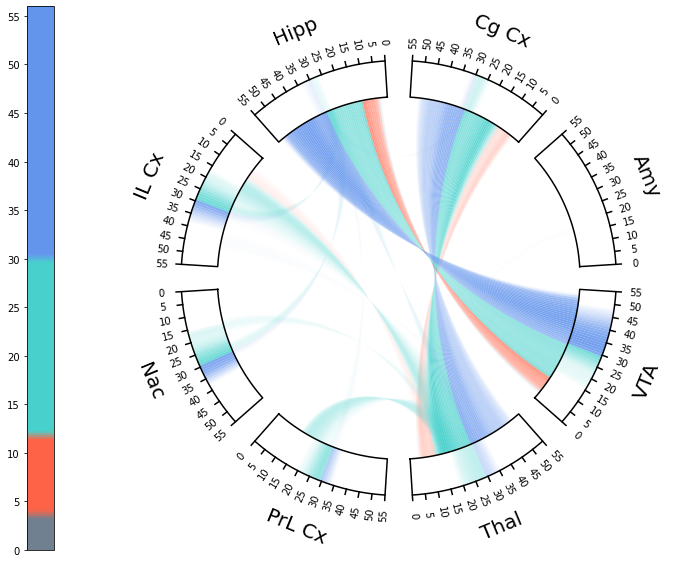

Net 1 Cutoff: 0.31103116273880005


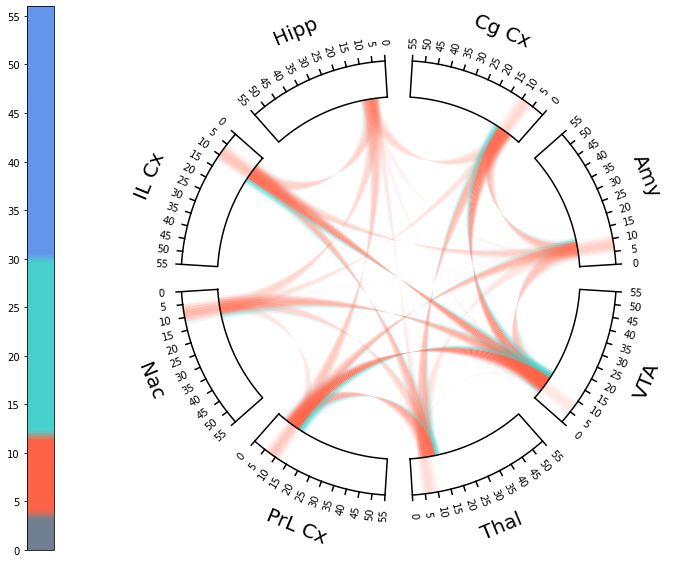

Net 2 Cutoff: 0.14020373821258544


In [16]:
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
#Delta 1-4, Theta 5-7, Alpha 8-10, Beta1 10-22, Beta2 23-30, Gamma 31-56

Color_1="slategray"
Color_2="tomato"
Color_3="mediumturquoise"
Color_4="cornflowerblue"


color_list = np.hstack([[Color_1 for _ in range(0,4)],
                        [Color_2 for _ in range(4,12)],
                        [Color_3 for _ in range(12,30)],
                        [Color_4 for _ in range(30,56)]])
cmap = colors.LinearSegmentedColormap.from_list('', color_list)
for i in range(3):
    s = model.project(mt_X_train)
    X_sup_recon = model.get_comp_recon(torch.Tensor(s).to("cpu"),i)
    X_recon = model.reconstruct(mt_X_train)

    recon_contribution = np.mean(X_sup_recon/X_recon,axis=0)
    rec_psd = recon_contribution[:len(anxInfo["powerFeatures"])]
    rec_coh = recon_contribution[len(anxInfo["powerFeatures"]):(len(anxInfo["powerFeatures"]) + len(anxInfo["cohFeatures"]))]
    rec_3d = reshapeData(rec_psd,rec_coh,8,56,anxInfo["powerFeatures"],anxInfo["cohFeatures"],anxInfo["area"])

    ax = chord_plot(rec_3d,
                    rois=anxInfo["area"],
                    freqs=np.arange(56),
                    max_alpha=0.9,
                    freq_ticks=np.arange(0,56,5),
                    min_max_quantiles=(0.85,0.9999),
                    cmap = cmap,
                    roi_fontsize=20,
                    fontfamily="sans",
                    figsize=(13,10)
                )
    cmappable = ScalarMappable(norm=Normalize(0,1), cmap=cmap)
    cbar = plt.colorbar(cmappable,location="left")
    cbar.set_ticks(np.arange(0,56,5)/56)
    cbar.set_ticklabels(np.arange(0,56,5))
    plt.savefig(plots_path + "color_corrected_final_circos_net_{}.pdf".format(i),format="pdf")
    plt.show()
    
    print("Net {} Cutoff: {}".format(i,np.quantile(rec_3d,.85)))
    